# Forecasting with constrained markov model

With the developed statistical hurricane track model (see markov.ipynb), we can now try forecasting with it! Downloading HURDAT2 data from NOAA, we can try to forecast all storms between 2005-2010 just to get a sense of how well the model is doing. This notebook also outlines future plans of expanding the project to constrain the statistical model with real physical data, thus making a hybrid stat-phys model, which would presumably perform better. 

For now, we are going to be extremely naive. No physical data, no analysis steps as the storm develops, just one initialization of the model and math. You'll see the model does a surprisingly decent job at predicting things. But like we expect, the true forecasting power of the model leaves a lot to be desired, guess we won't be replacing the national hurricane center just yet. 

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import geodesic
import xarray as xr
from concurrent.futures import ProcessPoolExecutor
from math import radians, sin, cos, sqrt, atan2

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

In [ ]:
# data loader functions
def load_storm_ibtracs(file_path):
    col_names = [
        "year", "month", "tc_number", "timestep", "basin_id",
        "lat", "lon", "min_pressure", "max_wind_speed", "r_max",
        "category", "landfall", "distance_to_land"]
    df = pd.read_csv(file_path, header=None, names=col_names)
    df["time_since_start"] =  pd.to_timedelta(df["timestep"] * 6, unit="h")
    df["storm_id"] = "idx_" + file_path[-5] + "_year_" + df["year"].astype(str) + "_number_" + df["tc_number"].astype(str)
    return df[["storm_id", "lat", "lon", "time_since_start", "basin_id", "min_pressure", "max_wind_speed"]]


def load_all_north_atlantic_storms():
    data_dir = os.path.join(project_root, "Data", "STORM_IBTraCS_data", "VERSIE4")
    all_data = []
    
    for i in range(10):
        filename = f"STORM_DATA_IBTRACS_NA_1000_YEARS_{i}.txt"
        file_path = os.path.join(data_dir, filename)
        if os.path.exists(file_path):
            df = load_storm_ibtracs(file_path)
            all_data.append(df)
        else:
            print(f"Warning: File not found - {file_path}")

    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

def parse_hurdat2(file_path, start_year=2005, end_year=2010):
    records = []
    current_storm = None

    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith("AL"):  # Storm header line
                parts = line.split(",")
                current_storm = {
                    "id": parts[0].strip(),
                    "name": parts[1].strip(),
                    "num_points": int(parts[2].strip())
                }
            else:  # Observation line
                if current_storm is None:
                    continue
                parts = line.split(",")
                date_str = parts[0].strip()
                year = int(date_str[:4])
                if year < start_year or year > end_year:
                    continue  # Skip observations outside range

                time_str = parts[1].strip()
                storm_type = parts[3].strip()
                lat_raw = parts[4].strip()
                lon_raw = parts[5].strip()
                
                # Convert lat/lon to decimal degrees
                lat = float(lat_raw[:-1]) * (1 if lat_raw[-1]=="N" else -1)
                lon = float(lon_raw[:-1]) * (1 if lon_raw[-1]=="E" else -1)

                wind = int(parts[6].strip()) if parts[6].strip() != "-999" else None
                pressure = int(parts[7].strip()) if parts[7].strip() != "-999" else None

                records.append({
                    "storm_id": current_storm["id"],
                    "storm_name": current_storm["name"],
                    "datetime": pd.to_datetime(date_str + time_str, format="%Y%m%d%H%M"),
                    "storm_type": storm_type,
                    "lat": lat,
                    "lon": lon,
                    "wind": wind,
                    "pressure": pressure
                })

    df = pd.DataFrame(records)
    return df

In [ ]:
# hurricane track model functions
def build_transition_matrix(df, lat_resolution=0.25, lon_resolution=0.25):
    """
    Build a transition matrix from storm track data by discretizing lat/lon into grid cells.

    Parameters:
        df (pd.DataFrame): Storm track data with "storm_id", "lat", "lon", and "time_since_start".
        lat_resolution (float): Grid resolution in degrees for latitude.
        lon_resolution (float): Grid resolution in degrees for longitude.

    Returns:
        transition_matrix (pd.DataFrame): Transition probabilities between grid cells.
        grid_index_map (dict): Mapping from grid cell (lat_idx, lon_idx) to matrix index.
    """
    # Discretize lat/lon into grid indices
    df["lat_idx"] = np.floor(df["lat"] / lat_resolution).astype(int)
    df["lon_idx"] = np.floor(df["lon"] / lon_resolution).astype(int)

    # Create a unique grid cell ID
    df["grid_cell"] = list(zip(df["lat_idx"], df["lon_idx"]))

    # Sort by storm_id and time
    df_sorted = df.sort_values(by=["storm_id", "time_since_start"])

    # Extract transitions
    transitions = []
    for storm_id, group in df_sorted.groupby("storm_id"):
        cells = group["grid_cell"].tolist()
        transitions += list(zip(cells[:-1], cells[1:]))

    # Count transitions
    transition_counts = {}
    for from_cell, to_cell in transitions:
        if from_cell not in transition_counts:
            transition_counts[from_cell] = {}
        if to_cell not in transition_counts[from_cell]:
            transition_counts[from_cell][to_cell] = 0
        transition_counts[from_cell][to_cell] += 1

    # Build index mapping
    unique_cells = set([cell for pair in transitions for cell in pair])
    grid_index_map = {cell: idx for idx, cell in enumerate(sorted(unique_cells))}

    # Initialize transition matrix
    n = len(grid_index_map)
    matrix = np.zeros((n, n))

    # Fill matrix with transition probabilities
    for from_cell, to_dict in transition_counts.items():
        from_idx = grid_index_map[from_cell]
        total = sum(to_dict.values())
        for to_cell, count in to_dict.items():
            to_idx = grid_index_map[to_cell]
            matrix[from_idx, to_idx] = count / total

    # Convert to DataFrame for readability
    transition_matrix = pd.DataFrame(matrix, index=grid_index_map.keys(), columns=grid_index_map.keys())

    return transition_matrix, grid_index_map

def simulate_storm_track(transition_matrix, grid_index_map, start_location, steps=50):
    """
    Simulate a storm track using a Markov process based on the transition matrix.

    Parameters:
        transition_matrix (pd.DataFrame): Square matrix of transition probabilities.
        grid_index_map (dict): Mapping from grid cell (lat, lon) to matrix index.
        steps (int): Number of steps to simulate.

    Returns:
        list: Sequence of (lat, lon) grid cells representing the storm track.
    """
    def coordinate_to_grid_cell(lat, lon, lat_res=0.25, lon_res=0.25, lon_offset=0):
        if lon_offset == 360 and lon < 0:
            lon += 360

        lat_idx = np.floor(lat / lat_res).astype(int)
        lon_idx = np.floor(lon / lon_res).astype(int)
        return (lat_idx, lon_idx)

    # Reverse the grid_index_map to get index -> (lat, lon)
    index_to_grid = {v: k for k, v in grid_index_map.items()}

    current_index = grid_index_map[coordinate_to_grid_cell(start_location[0], start_location[1])]
    track = [index_to_grid[current_index]]

    for _ in range(steps):
        # Get the transition probabilities from the current state
        probs = transition_matrix.iloc[current_index].values

        # If all probabilities are zero, stop the simulation
        if probs.sum() == 0:
            break

        # Normalize probabilities in case of rounding issues
        probs = probs / probs.sum()

        # Choose the next state based on the transition probabilities
        next_index = np.random.choice(len(probs), p=probs)
        track.append(index_to_grid[next_index])
        current_index = next_index

    return track

def pad_tracks(tracks, length):
    padded = []
    for track in tracks:
        if len(track) < length:
            # Pad with (np.nan, np.nan)
            pad_len = length - len(track)
            track = track + [(np.nan, np.nan)] * pad_len
        padded.append(track)
    return np.array(padded)


def monte_carlo_storms(transition_matrix, grid_index_map, start_location, steps=50, n_tracks=1000):
    tracks, expected_length = [], steps+1
    for _ in range(n_tracks):
        tracks.append(simulate_storm_track(transition_matrix, grid_index_map, start_location, steps))

    tracks = pad_tracks(tracks, expected_length)
    tracks = np.array(tracks)
    lats, lons = tracks[:,:,0], tracks[:,:,1]

    mean_track = [np.nanmean(lats, axis=0), np.nanmean(lons, axis=0)]
    
    return tracks, mean_track

R = 6371 # earth radius in k

def haversine(lat1, lon1, lat2, lon2):
    dlat, dlon = radians(lat2-lat1), radians(lon2-lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

def cone_of_uncertainty(tracks, mean_track):
    n_tracks, n_steps = len(tracks), len(tracks[0])
    distances = np.zeros((n_tracks, n_steps))

    for i in range(n_tracks):
        for j in range(n_steps):
            lat, lon = tracks[i, j]
            mean_lat, mean_lon = mean_track[j]
            if np.isnan(lat) or np.isnan(lon):
                distances[i,j] = np.nan
                continue
            distances[i,j] = haversine(lat, lon, mean_lat, mean_lon)
    
    std_distances = np.nanstd(distances, axis=0)
    conf_inter = 1.96*std_distances
            
    return conf_inter

In [61]:
north_atlantic_data = load_all_north_atlantic_storms()
transition_matrix, grid_index_map = build_transition_matrix(north_atlantic_data, lat_resolution=0.25, lon_resolution=0.25)

## HURDAT2 Data
Atlantic hurricane database (HURDAT2) 1851-2024. This dataset was updated on April 4th, 2025 to include in the 2024 hurricane season. This dataset (known as Atlantic HURDAT2) has a comma-delimited, text format with six-hourly information on the location, maximum winds, central pressure, and (beginning in 2004) size of all known tropical cyclones and subtropical cyclones. The original HURDAT database has been retired.

### Concentrating on 2005-2010
While the dataset extends to a huge range, I am compelled to evaluate the model for storms between 2005-2010. For two main reasons: it contains Katrina and I am from New Orleans, it is a narrow enough date range I can also download ERA5 reanalysis data to further improve the model with "real data" in the future. This will be something I will work on more in the future. 

The range 2005-2010 will give us over 50 storms, so plenty to get a basic sense of how the model does as a forecast tool. It also gives a decent range of locations, durations, and weird tracks caused by phenomena and weather patterns not observed by the model. So we can see how it does under a range of conditions. 

Landsea, C. W. and J. L. Franklin, 2013: Atlantic Hurricane Database Uncertainty and Presentation of a New Database Format. Mon. Wea. Rev., 141, 3576-3592.

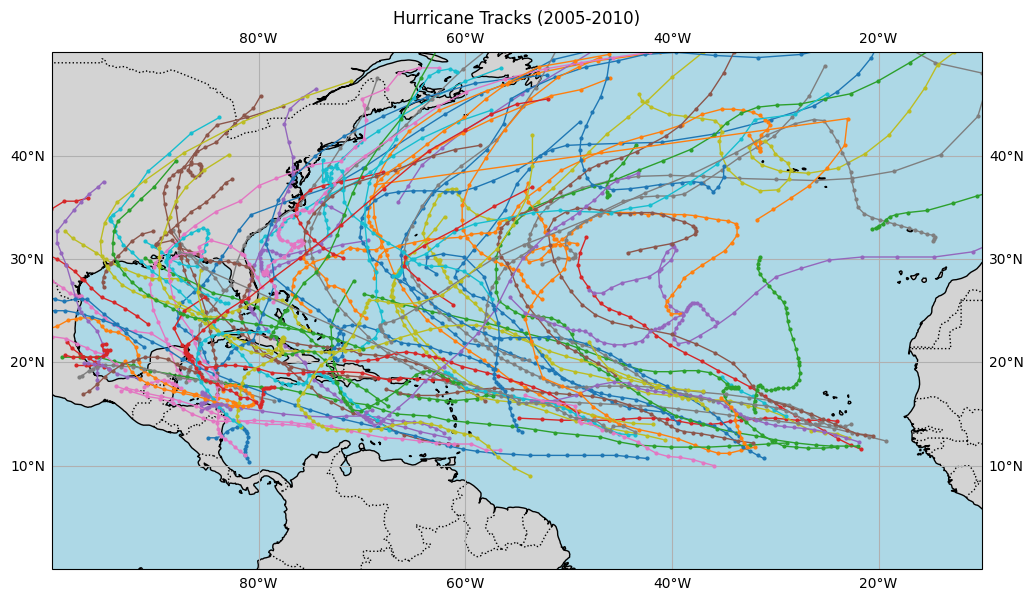

In [211]:
file_path = project_root + "/Data/HURDAT2/track_data.txt"  # make sure path is correct
real_storms = parse_hurdat2(file_path)

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100, -10, 0, 50], crs=ccrs.PlateCarree())  # Atlantic basin
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Plot each storm track
for storm_id, storm_data in real_storms.groupby("storm_name"):
    ax.plot(
        storm_data["lon"], storm_data["lat"],
        marker="o", markersize=2, linewidth=1,
        label=storm_id
    )

ax.set_title("Hurricane Tracks (2005-2010)")
plt.show()

In [199]:
forecast = {}

for id, group in real_storms.groupby("storm_id"):
    group = group.sort_values("datetime")
    start_lat, start_lon = group.iloc[0][["lat"]].values, group.iloc[0][["lon"]].values + 360 # lon is stored with wrong convention
    start_lat, start_lon = start_lat[0], start_lon[0]
    start_lat, start_lon = round(start_lat*4)/4, round(start_lon*4)/4
    
    # run the monte carlo simulation
    tracks, mean_track = monte_carlo_storms(
        transition_matrix, 
        grid_index_map, 
        start_location=(start_lat, start_lon), 
        steps=len(group), 
        n_tracks=1000
        )
    tracks, mean_track = np.array(tracks), np.array(mean_track).T # mean track needs to be rotated for confidence interval calculation

    ci_95 = cone_of_uncertainty(tracks, mean_track)
    
    forecast[id] = {
            "storm_name": group.iloc[0]["storm_name"],
            "observed_track": group[["lat", "lon"]].to_numpy().T, # rotate observed track for easier plotting
            "simulated_tracks": tracks,       # shape (n_tracks, steps+1, 2)
            "ensemble_mean": mean_track,       # (2, steps+1).T for (steps+1,2)
            "cone_of_uncertainty": ci_95
        }

/var/folders/rb/c30wr3y96n75ld0cthq89chh0000gn/T/ipykernel_28013/2496984221.py:125: RuntimeWarning: Mean of empty slice
  mean_track = [np.nanmean(lats, axis=0), np.nanmean(lons, axis=0)]
/Users/mfranssen/Documents/VSCode/TC_Model/TCvenv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/rb/c30wr3y96n75ld0cthq89chh0000gn/T/ipykernel_28013/2496984221.py:125: RuntimeWarning: Mean of empty slice
  mean_track = [np.nanmean(lats, axis=0), np.nanmean(lons, axis=0)]
/Users/mfranssen/Documents/VSCode/TC_Model/TCvenv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/rb/c30wr3y96n75ld0cthq89chh0000gn/T/ipykernel_28013/2496984221.py:125: RuntimeWarning: Mean of empty slice
  mean_track = [np.nanmean(lats, axis=0), np

In [ ]:
# plotting all the forecasted tracks
def gridcell_to_latlon(lat_idx, lon_idx, lat_res=0.25, lon_res=0.25):
    lat = (lat_idx + 0.5) * lat_res
    lon = (lon_idx + 0.5) * lon_res
    return (lat, lon)

for id,data in forecast.items():
    # track plotting variables
    forecasted_track, observated_track, confidence_interval = data["ensemble_mean"], data["observed_track"], data["cone_of_uncertainty"]
    storm_name = data["storm_name"]

    # get the forecast track coordinates translated from grid_cell using index
    forecast_latlon = [gridcell_to_latlon(forecast_lat_idx, forecast_lon_idx) for forecast_lat_idx, forecast_lon_idx in forecasted_track]
    forecast_lat, forecast_lon = zip(*forecast_latlon)

    # Plot the map
    plt.figure(figsize=(14, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-100, -10, 0, 60], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

    # add forecast line and confidence interval
    ax.plot(forecast_lon, forecast_lat, color="blue", linewidth=2, transform=ccrs.PlateCarree(), label="Forecast Track")
    for (lat, lon), radius_km in zip(forecast_latlon, confidence_interval):
        if np.isnan(radius_km) or np.isnan(lat) or np.isnan(lon):
            continue
        circle = geodesic.Geodesic().circle(lon=lon, lat=lat, radius=radius_km * 1000, n_samples=1000, endpoint=False)
        ax.plot(*zip(*circle), color="blue", alpha=0.3, transform=ccrs.PlateCarree())

    # add observed hurricane track
    ax.plot(observated_track[1], observated_track[0], color="red", linewidth=2, transform=ccrs.PlateCarree(), label="Observed Track")

    # add storm name and legend
    ax.text(0.99, 0.01,
            storm_name,
            transform=ax.transAxes,
            ha="right", va="bottom",
            fontsize=15, color="black"
            )
    ax.legend()
    
    # save and close the figure
    plt.tight_layout()
    plt.savefig(project_root + "/Outputs/forecasts/" + storm_name + ".png")
    plt.close()

In [210]:
# animating all the forecasted tracks

i = 0
for id,data in forecast.items():
    # track plotting variables
    forecasted_track, observated_track, confidence_interval = data["ensemble_mean"], data["observed_track"], data["cone_of_uncertainty"]
    storm_name = data["storm_name"]

    # get the forecast track coordinates translated from grid_cell using index
    forecast_latlon = [gridcell_to_latlon(forecast_lat_idx, forecast_lon_idx) for forecast_lat_idx, forecast_lon_idx in forecasted_track]
    forecast_lat, forecast_lon = zip(*forecast_latlon)

    
    for step in range(len(observated_track[0])):

        # Plot the map
        plt.figure(figsize=(14, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent([-100, -10, 0, 60], crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=":")
        ax.add_feature(cfeature.LAND, facecolor="lightgray")
        ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

        # add forecast line and confidence interval
        ax.plot(forecast_lon, forecast_lat, color="blue", linewidth=2, transform=ccrs.PlateCarree(), label="Forecast Track")
        for (lat, lon), radius_km in zip(forecast_latlon, confidence_interval):
            if np.isnan(radius_km) or np.isnan(lat) or np.isnan(lon):
                continue
            circle = geodesic.Geodesic().circle(lon=lon, lat=lat, radius=radius_km * 1000, n_samples=1000, endpoint=False)
            ax.plot(*zip(*circle), color="blue", alpha=0.3, transform=ccrs.PlateCarree())

        # add observed hurricane track
        ax.plot(observated_track[1][0:step], observated_track[0][0:step], color="red", linewidth=2, transform=ccrs.PlateCarree(), label="Observed Track")

        # add storm name and legend
        ax.text(0.99, 0.01,
            storm_name,
            transform=ax.transAxes,
            ha="right", va="bottom",
            fontsize=15, color="black"
            )
        ax.legend()
    
        # save and close the figure
        plt.tight_layout()
        plt.savefig(project_root + "/Outputs/animation/" + str(i) + ".png")
        plt.close()

        i += 1